# Sistema de recomendaciones LicitaLAB
#### Basado en las descripciones de los usuarios y las categorías en que ofrecen.

Si es primera vez que se lanza este PyNotebook, se generarán un grupo de archivos, necesarios para llevar a cabo las recomendaciones. 

### Imports y configuraciones

In [24]:
import os
from utils.RecommenderSystem import RecommenderSystem  
import pandas as pd
from unidecode import unidecode 
from tqdm import tqdm
import torch 
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    # Set the GPU device (assuming you have at least one GPU)
    gpu_device = 0  # You can change this to the index of the GPU you want to use
    torch.cuda.set_device(gpu_device)
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(gpu_device)}")
else:
    # If no GPU is available, use the CPU
    device = torch.device("cpu")
    print("No GPU available, using CPU")


Using GPU: NVIDIA GeForce RTX 3060


Agregar la ubicación donde se encuentra el .csv con el que se genera el espacio de usuarios.

In [25]:
train_path = 'C:\\Users\\magda\\OneDrive\\Escritorio\\MDS_licitalab\\marzo.csv'
test_path =  'C:\\Users\\magda\\OneDrive\\Escritorio\\MDS_licitalab\\abril.csv'

Carga el Dataset.

In [26]:
train = pd.read_csv(train_path) 
train['feature_vector'] = train['agileoffereditemscategoriaofertada'] + ' ' + train['agileoffereditemsdescripcionofertada']
train['feature_vector'] = train['feature_vector'].apply(lambda x: unidecode(str(x)).lower())

test = pd.read_csv(test_path)
test['feature_vector'] = test['agileoffereditemscategoriaofertada'] + ' ' + test['agileoffereditemsdescripcionofertada']
test['feature_vector'] = test['feature_vector'].apply(lambda x: unidecode(str(x)).lower())


In [27]:
"""gb = df.groupby(by =['taxnumberprovider']).agg({'agilebuyingscode':'nunique'})
gb = gb.sort_values(by = 'agilebuyingscode')
gb.rename(columns={'agilebuyingscode': 'all users'}, inplace=True)

fig,ax = plt.subplots()
gb.plot.density(title = "densidad de compras agiles para todos los usuarios", ax = ax)
  
n_strings = 10
qualifying_users =  gb[gb['all users'] >= n_strings]
qualifying_users.rename(columns={'all users': 'qualifying users'}, inplace=True)

qualifying_users.plot.density(title = 'densidad de compras agiles para usuarios n>10',ax = ax, legend = True)
ax.set_xlim(-200, 200) """

'gb = df.groupby(by =[\'taxnumberprovider\']).agg({\'agilebuyingscode\':\'nunique\'})\ngb = gb.sort_values(by = \'agilebuyingscode\')\ngb.rename(columns={\'agilebuyingscode\': \'all users\'}, inplace=True)\n\nfig,ax = plt.subplots()\ngb.plot.density(title = "densidad de compras agiles para todos los usuarios", ax = ax)\n  \nn_strings = 10\nqualifying_users =  gb[gb[\'all users\'] >= n_strings]\nqualifying_users.rename(columns={\'all users\': \'qualifying users\'}, inplace=True)\n\nqualifying_users.plot.density(title = \'densidad de compras agiles para usuarios n>10\',ax = ax, legend = True)\nax.set_xlim(-200, 200) '

Lanzar el recomendador. Si no encuentra los archivos necesarios iniciará un proceso de generación de estos. Se demora bastante, pero no deberían haber problemas.

In [28]:
RS = RecommenderSystem(train,
                       test,
                       save_path = os.getcwd())

Initializing Recommender System
The current directory is c:\Users\magda\OneDrive\Escritorio\MDS_licitalab\Modeling\hito_4
Using GPU: NVIDIA GeForce RTX 3060
Initializing User Space
Directory 'c:\Users\magda\OneDrive\Escritorio\MDS_licitalab\Modeling\hito_4\userspace_data' created or already exists.
['BERT_model.pkl', 'BERT_tokenizer.pkl', 'kmeans_clusters.csv', 'kmeans_model.pkl', 'vectorized_corpus.csv']
All necesary files have been found.
Loaded cluster model
Loaded BERT_model
Loaded tokenizer
Loaded vectorized data
Loaded kmeans data


Successfully removed directory: c:\Users\magda\OneDrive\Escritorio\MDS_licitalab\Modeling\hito_4\userspace_data. Re-Initializing userspace
Directory 'c:\Users\magda\OneDrive\Escritorio\MDS_licitalab\Modeling\hito_4\userspace_data' created or already exists.
Generating User Space
Se han removido 72.83% de taxnumberproviders, por tener < 10 licitaciones. 
 El numero de usuarios para crear el corpus será 1846.


Selecting strings from each user: 100%|██████████| 1846/1846 [00:18<00:00, 99.17it/s] 
Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at 

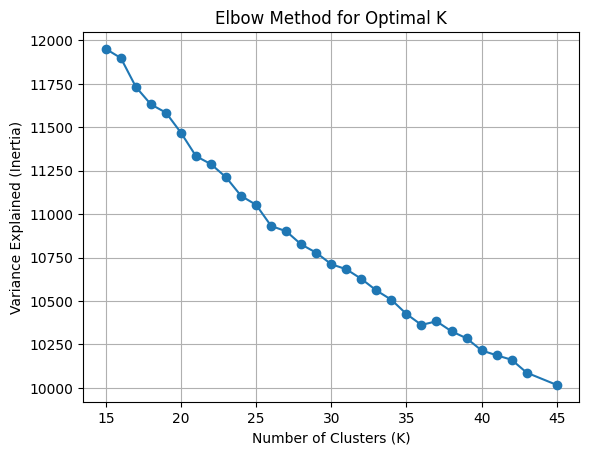

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Optimal n_clusters is 17

Silhouette Scores:
KMeans: 0.33966
Agglomerative Clustering: 0.30198124


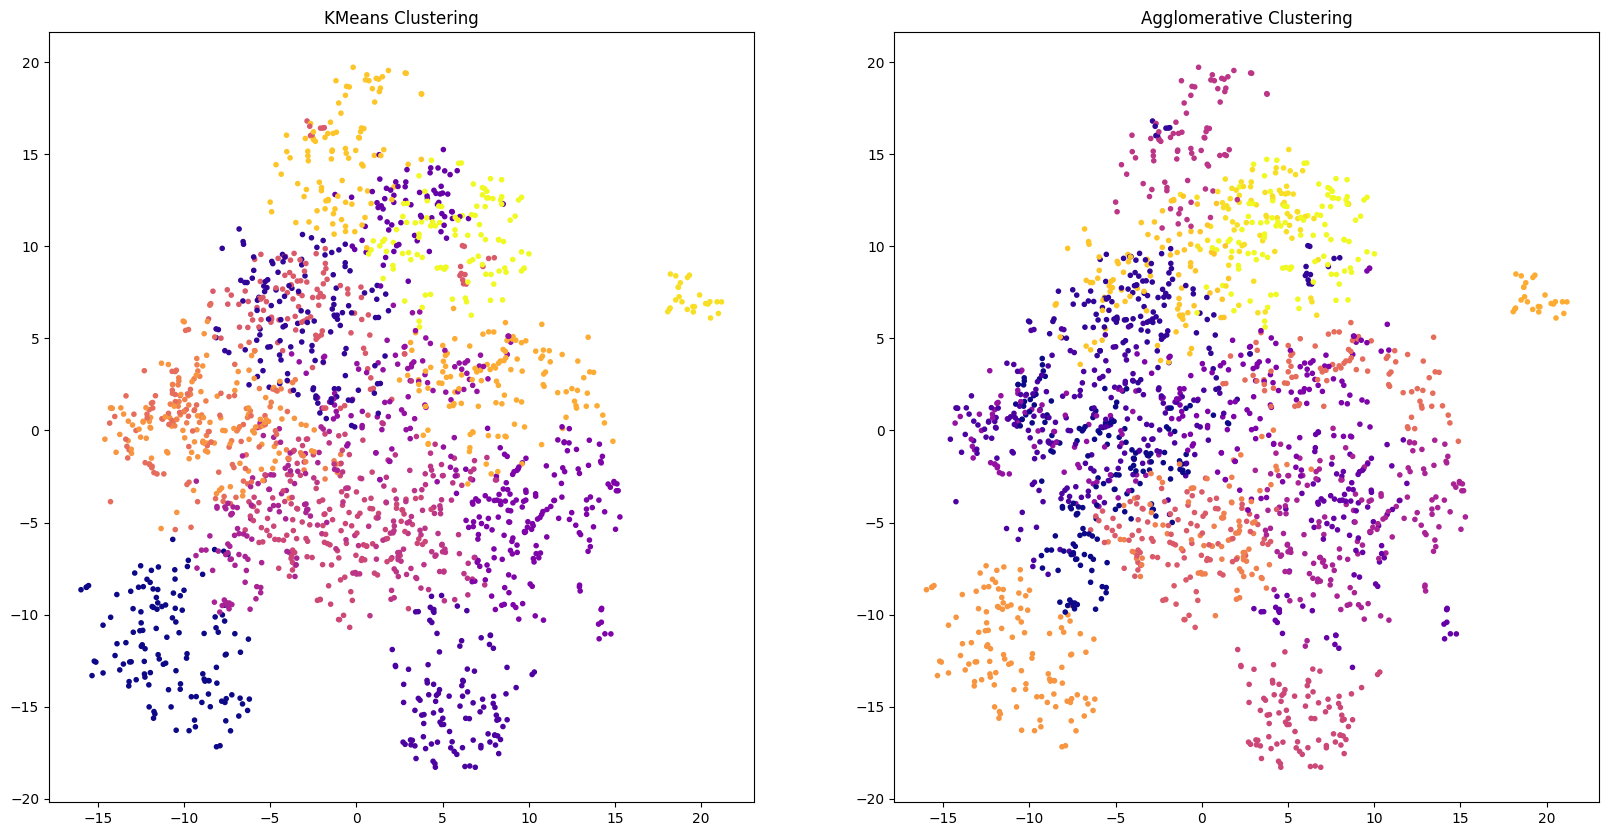

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


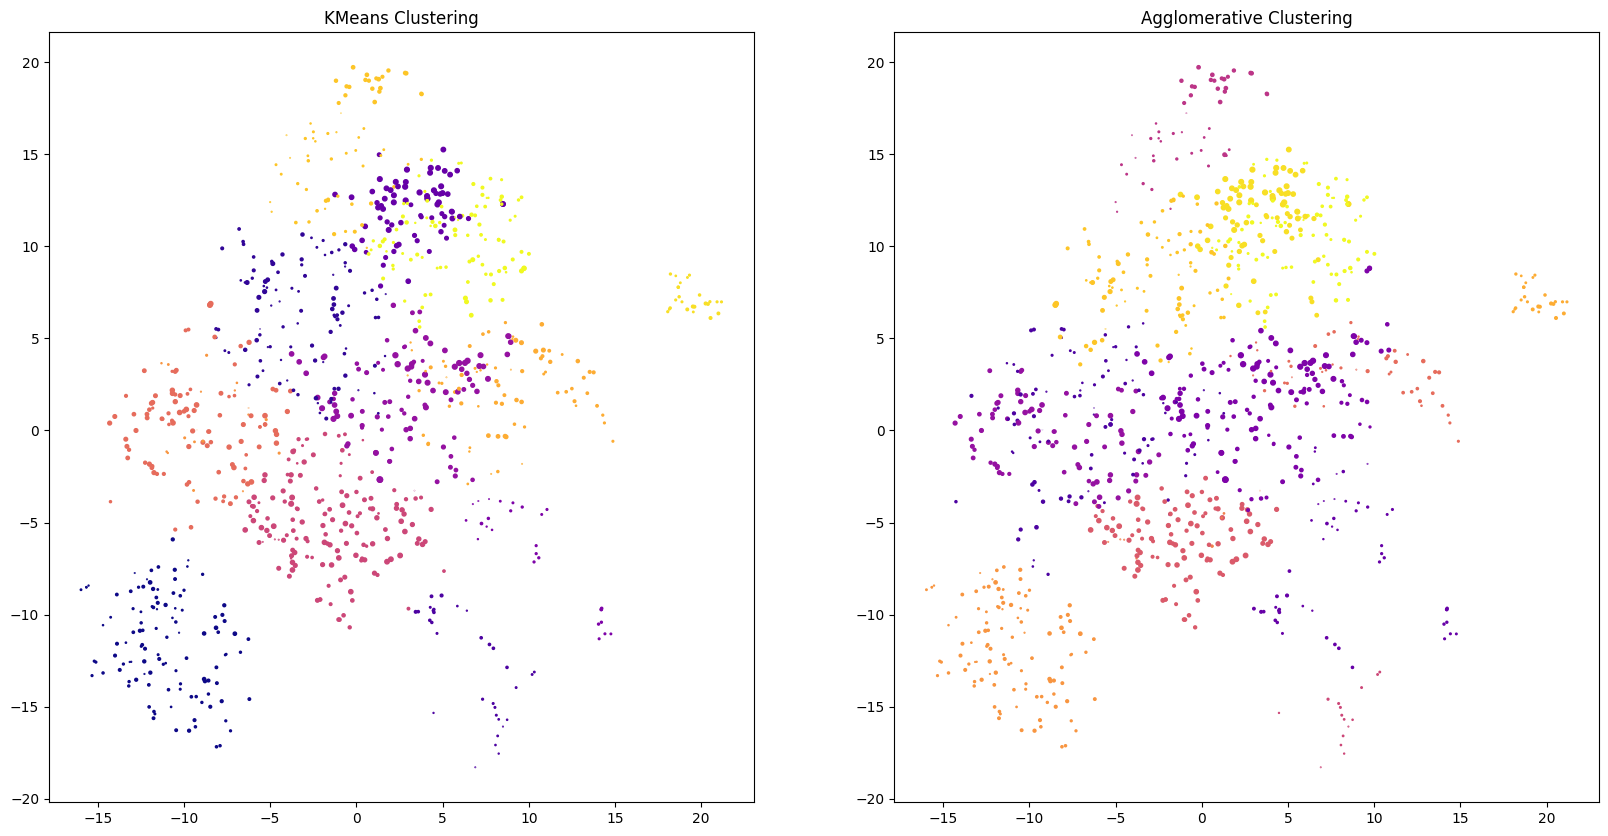

Exporting Kmeans model
Exporting Kmeans clusters
Exporting vectorizer model
Done
Exporting vectorized corpus


In [29]:
RS.regenerate_system()

### Predecir recomendaciones

Se le entrega el string del rut al sistema recomendador a traves de la función `predict()`. El sistema retorna el número de cluster al que el usuario ha sido asignado y un dataframe con las compras ágiles recomendadas. 

In [30]:
ruts = test['taxnumberprovider'].sample(n =1) 
n_cluster,gg = RS.predict(ruts.values[0])

(76.830.090-9) data point belongs to cluster 2


Agregando un poco de post-procesamiento se pueden encontrar visualizaciones de interés.

In [31]:
gg.query(f"Cluster == {n_cluster}")

,organismosolicitante,agilebuyingscode,agilebuyingsdescription,agilebuyingsstatus,agilebuyingscurrency,agilebuyingsavailableamount,agileitemsname,agileitemsmp_id,agileitemsproductcategory,agileoffereditemsproductoofertado,agileoffereditemscategoriaofertada,agileoffereditemsdescripcionofertada,agileoffereditemspreciototal,taxnumberprovider,provideractivity,adjudicada,feature_vector_x,feature_vector_y,Cluster
70,61.102.025-2,3178-268-COT23,REQUISITOS: 1.- SE SOLICITA COTIZAR LA TOTALID...,Cancelada,$,1600000.0,Sondas quirúrgicas,42293603,"Bougies quirúrgicos, sondas, obturadores y pro...",Sondas quirúrgicas,"Bougies quirúrgicos, sondas, obturadores y pro...",Cotización_0020149516. Despacho en caja según ...,1100000.0,77.478.120-k,VENTA AL POR MAYOR DE PRODUCTOS FARMACEUTICOS|...,False,"bougies quirurgicos, sondas, obturadores y pro...","bougies quirurgicos, sondas, obturadores y pro...",2.0
115,69.073.500-8,3232-152-COT23,INSUMOS E INTRUMENTOS MEDICOS - SC N°78532 DID...,OC Emitida,$,1873000.0,Esponjas de gasa,42311512,Equipamiento y suministros médicos / Productos...,Esponjas de gasa,Equipamiento y suministros médicos / Productos...,"-SCM PHARMA SPA, F:2-25104550-SE ADJUNTA COTIZ...",282780.0,77.337.544-5,VENTA AL POR MAYOR DE PRODUCTOS FARMACEUTICOS ...,False,equipamiento y suministros medicos / productos...,equipamiento y suministros medicos / productos...,2.0
169,69.191.200-0,4103-141-COT23,COMPRA DE DETERGENTE ENZIMATICO PARA USO EN EL...,OC Emitida,$,270000.0,Detergentes o limpiadores de instrumentos,42281704,Equipamiento y suministros médicos / Productos...,Detergentes o limpiadores de instrumentos,Soluciones y equipo de limpieza pre-esteriliza...,DETERGENTE ENZIMÁTICO PH NEUTRO PARA LAVADO DE...,330000.0,78.921.550-2,VENTA AL POR MENOR DE ARTICULOS ORTOPEDICOS| V...,False,soluciones y equipo de limpieza pre-esteriliza...,soluciones y equipo de limpieza pre-esteriliza...,2.0
171,69.191.200-0,4103-141-COT23,COMPRA DE DETERGENTE ENZIMATICO PARA USO EN EL...,OC Emitida,$,270000.0,Detergentes o limpiadores de instrumentos,42281704,Equipamiento y suministros médicos / Productos...,Detergentes o limpiadores de instrumentos,Soluciones y equipo de limpieza pre-esteriliza...,DETERGENTE ENZIMÁTICO PH NEUTRO PARA LAVADO DE...,420000.0,76.301.407-K,Insumos Clinicos,False,soluciones y equipo de limpieza pre-esteriliza...,soluciones y equipo de limpieza pre-esteriliza...,2.0
175,69.191.200-0,4103-141-COT23,COMPRA DE DETERGENTE ENZIMATICO PARA USO EN EL...,OC Emitida,$,270000.0,Detergentes o limpiadores de instrumentos,42281704,Equipamiento y suministros médicos / Productos...,Detergentes o limpiadores de instrumentos,Soluciones y equipo de limpieza pre-esteriliza...,DETERGENTE ENZIMÁTICO PH NEUTRO PARA LAVADO DE...,530100.0,79.581.120-6,"FABRICACION DE PRODUCTOS FARMACEUTICOS, SUSTAN...",False,soluciones y equipo de limpieza pre-esteriliza...,soluciones y equipo de limpieza pre-esteriliza...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493735,60.910.000-1,5178-1118-COT23,"SE REQUIEREN ARTICULOS MEDICOS,SE DEBE ADJUNTA...",OC Emitida,$,600000.0,Agujas mariposa,42142507,Equipamiento y suministros médicos / Suministr...,Cintas adhesivas médicas y quirúrgicas para el...,Cintas adhesivas médicas y quirúrgicas y produ...,CINTA ADHESIVA MEDICA MICROPORE 1535-1 (2 5 CM...,15600.0,76.167.536-2,VENTA AL POR MAYOR DE PRODUCTOS FARMACEUTICOS|...,False,cintas adhesivas medicas y quirurgicas y produ...,"agujas clinicas aguja 19 g x 1.50"" jeringas y ...",2.0
493739,60.910.000-1,5178-1118-COT23,"SE REQUIEREN ARTICULOS MEDICOS,SE DEBE ADJUNTA...",OC Emitida,$,600000.0,Agujas mariposa,42142507,Equipamiento y suministros médicos / Suministr...,Jeringas médicas con aguja,Jeringas y accesorios,\tJERINGA HIPODERMICA CONTROLADA 20CC CON AGUJ...,23709.0,77.337.544-5,VENTA AL POR MAYOR DE PRODUCTOS FARMACEUTICOS ...,False,jeringas y accesorios \tjeringa hipodermica co...,equipamiento y suministros medicos / productos...,

In [32]:
display(gg.query(f"Cluster == {n_cluster}").groupby(by =['taxnumberprovider','agilebuyingscode','agilebuyingsdescription','agileitemsproductcategory']).count())

organismosolicitante  \
taxnumberprovider agilebuyingscode   agilebuyingsdescription                            agileitemsproductcategory                                                  
14.016.967-6      1003473-1137-COT23 AGUA BIDESTILADA 10 ML  PLASTICA (medic).\nPROG... Medicamentos y productos farmacéuticos / Medica...                     2   
                  1003473-1243-COT23 \nAGUA BIDESTILADA 500 ML PEDIDO ESPECIAL NOTA ... Medicamentos y productos farmacéuticos / Medica...                     2   
                  1003473-1262-COT23 AGUA BIDESTILADA 500 ML PEDIDO ESPECIAL NOTA N°... Medicamentos y productos farmacéuticos / Medica...                     1   
                  1003473-1268-COT23 SODIO CLORURO 0.9% 20 ML //PROGRAMACION SUERO M... Medicamentos y productos farmacéuticos / Agente...                     1   
                  1057495-304-COT23  SE SOLICITA COTIZACION POR 1980 BOTELLAS DE AGU... Alimentos, bebidas y tabaco / Bebidas / Bebidas...                     1   
...                                                                                                                                                          ...   
99.565.040-1      5209-609-COT23     SE SOLICITA EN COTIZACIÓN INDICAR VENCIMIENTO D... Medicamentos y productos farmacéuticos / Medica...                     1   
                  5740-19-COT23      ADQUISICION DE FARMACOS PARA EL POLICLINICO DEL... Equipamiento y suministros médicos / Artículos ...                     3   
                  608-1704-COT23     SE REQUIERE  GEL RECUBRIMIENTO PARA LESIONES BU... Equipamiento y suministros médicos / Ayuda para...                     1   
                  608-1782-COT23     SE REQUIERE LA COMPRA DE VINBLASTINA 10 MG/ML FA   Medicamentos y productos farmacéuticos / Agente...                     1   
                  608-2064-COT23     SE REQUIERE CAFEINA CITRATO 10 MG/ML JARABE 30 ... Medicamentos y productos farmacéuticos / Medica...                     3   

                                                                                                                                            agilebuyingsstatus  \
taxnumberprovider agilebuyingscode   agilebuyingsdescription                            agileitemsproductcategory                                                
14.016.967-6      1003473-1137-COT23 AGUA BIDESTILADA 10 ML  PLASTICA (medic).\nPROG... Medicamentos y productos farmacéuticos / Medica...                   2   
                  1003473-1243-COT23 \nAGUA BIDESTILADA 500 ML PEDIDO ESPECIAL NOTA ... Medicamentos y productos farmacéuticos / Medica...                   2   
                  1003473-1262-COT23 AGUA BIDESTILADA 500 ML PEDIDO ESPECIAL NOTA N°... Medicamentos y productos farmacéuticos / Medica...                   1   
                  1003473-1268-COT23 SODIO CLORURO 0.9% 20 ML //PROGRAMACION SUERO M... Medicamentos y productos farmacéuticos / Agente...                   1   
                  1057495-304-COT23  SE SOLICITA COTIZACION POR 1980 BOTELLAS DE AGU... Alimentos, bebidas y tabaco / Bebidas / Bebidas...                   1   
...                                                                                                                                                        ...   
99.565.040-1      5209-609-COT23     SE SOLICITA EN COTIZACIÓN INDICAR VENCIMIENTO D... Medicamentos y productos farmacéuticos / Medica...                   1   
                  5740-19-COT23      ADQUISICION DE FARMACOS PARA EL POLICLINICO DEL... Equipamiento y suministros médicos / Artículos ...                   3   
                  608-1704-COT23     SE REQUIERE  GEL RECUBRIMIENTO PARA LESIONES BU... Equipamiento y suministros médicos / Ayuda para...                   1   
                  608-1782-COT23     SE REQUIERE LA COMPRA DE VINBLASTINA 10 MG/ML FA   Medicamentos y productos farmacéuticos / Agente...                   1   
                  608-2064-COT23     SE REQUIERE CAFEINA CITRAT